In [1]:
# Path to Netcdf files
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io as cio
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter, Gridliner
import math
from tqdm import tqdm

In [2]:
def haversine(lat1, lon1, lat2, lon2):
    # convert to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    # calculate haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371 # Earth's radius in km
    return c * r

def find_nearest(lat, lon, lats, lons, n=9):
    distances = []
    for i in range(len(lats)):
        d = haversine(lat, lon, lats[i], lons[i])
        distances.append((d, i))
    distances.sort()
    nearest = [(lats[distances[i][1]], lons[distances[i][1]], distances[i][0]) for i in range(n)]
    return nearest

In [3]:
path='/home/jstreffi/thesis/data/'

grids=Dataset(path+'/grids.nc')
masks=Dataset(path+'/masks.nc')

# Loading data
lons = grids.variables['feom.lon'][0]
lats = grids.variables['feom.lat'][0]

lats_oifs = grids.variables['A096.lat'][0]
lons_oifs = grids.variables['A096.lon'][0]

mask_oifs = masks.variables['A096.msk'][0]

 22%|█████████████▌                                                | 8782/40320 [00:01<00:06, 4680.74it/s]

273.2516860093698
268.821449802288
273.00879828175226
266.4096650041549
273.58889704783746
257.67952413191114
260.8746713195671
274.49529432358855
286.9446440703318


 22%|██████████████▏                                                | 9052/40320 [00:18<01:28, 354.53it/s]

274.4358399431589
266.03880123203476


 22%|██████████████▏                                                | 9054/40320 [00:22<01:55, 271.10it/s]

270.38564683301104
275.3360499806594


 23%|██████████████▍                                                | 9247/40320 [00:26<02:25, 213.75it/s]

273.68488834888745
290.474120812152
269.2974832249725
280.8027042125612
279.0381304123191
259.15413803615525


 23%|██████████████▌                                                | 9326/40320 [00:37<04:38, 111.44it/s]

266.53822752465436


 23%|██████████████▊                                                 | 9327/40320 [00:39<05:11, 99.65it/s]

274.2552475261313


 24%|██████████████▉                                                | 9597/40320 [00:40<04:49, 106.27it/s]

283.59612868445583
292.9090784145545
288.3381774349913
273.5447456385327
277.3386542610482
270.90641744721387


 24%|███████████████▎                                                | 9644/40320 [00:51<09:45, 52.38it/s]

274.4778637375679


 24%|███████████████▋                                                | 9877/40320 [00:53<08:17, 61.19it/s]

284.30395798102444
280.9927083007284
274.0798359924786
273.39147433042916
287.3975573796304
283.9970980357007


 25%|███████████████▋                                                | 9913/40320 [01:04<15:19, 33.08it/s]

283.97311583652953


 25%|███████████████▉                                               | 10160/40320 [01:05<11:26, 43.93it/s]

295.68931298041167
292.7999937022207
281.0292512905811
284.2822463643838
280.65126430232397
277.2217085356611


 25%|███████████████▉                                               | 10160/40320 [01:17<11:26, 43.93it/s]

293.1339361036661


 25%|███████████████▉                                               | 10167/40320 [01:18<23:34, 21.32it/s]

284.792120761191


 26%|████████████████▎                                              | 10448/40320 [01:20<14:42, 33.84it/s]

306.8881930275834
285.09282315249965
276.2469117945712
293.8509880893247
284.8876533095505
281.9758508667095


 26%|████████████████▎                                              | 10473/40320 [01:30<23:58, 20.75it/s]

280.5294263582218


 27%|████████████████▊                                              | 10740/40320 [01:32<14:33, 33.86it/s]

312.92689518042755
298.93769253577574
287.33066720720655
301.29143017415123
291.0140066706056
286.133440695246


 27%|████████████████▊                                              | 10757/40320 [01:42<25:15, 19.51it/s]

292.6514002105516


 27%|█████████████████▏                                             | 11035/40320 [01:44<14:43, 33.16it/s]

332.59610893235316
327.8417102583957
323.4958249612568
295.6640427010329
300.44359012234946
290.09453959146055
298.29153294700836


100%|██████████████████████████████████████████████████████████████| 40320/40320 [01:57<00:00, 343.73it/s]

274.3736317145559


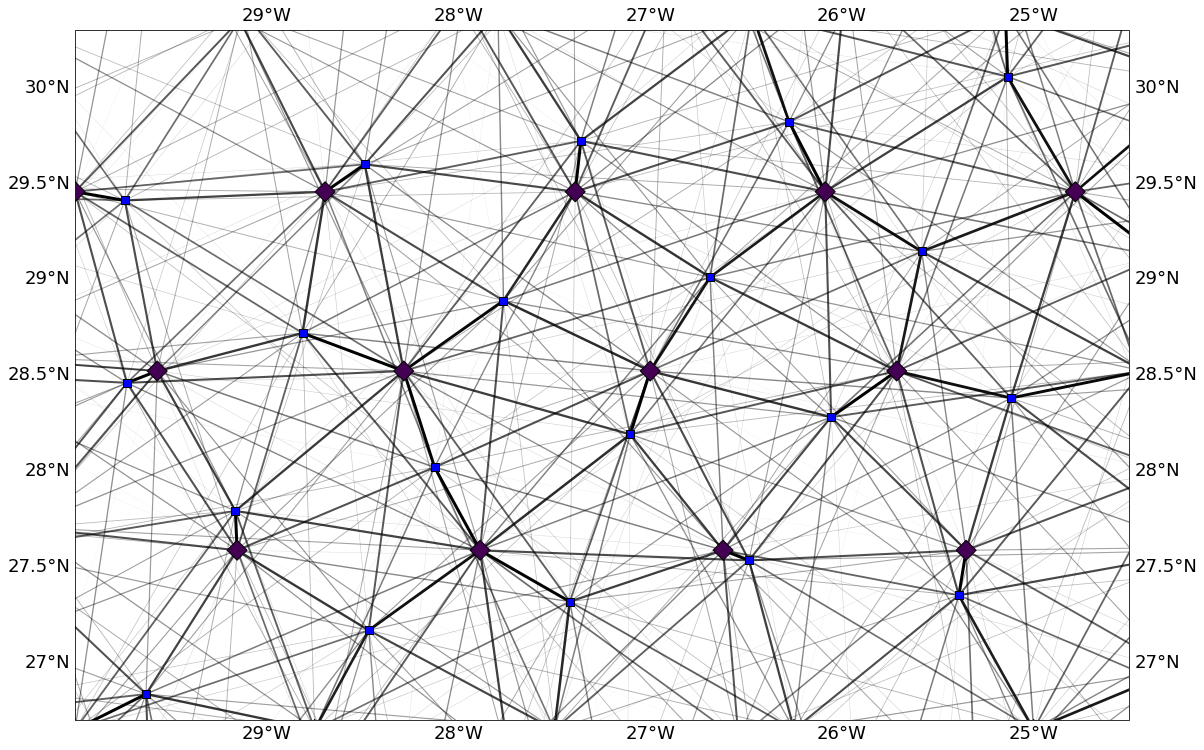

In [12]:
location='atlantic' # 'east med'
n_neighbour=25
plot_connections=True

if location =='north_sea':
    min_lon=5.3
    max_lon=10.8
    min_lat=52.7
    max_lat=56.3
    cities = {
    'Bremerhaven': (53.549999, 8.583333),
    'Bremen': (53.077939, 8.801709),
    'Hamburg': (53.551086, 9.993682),
    'Oldenburg': (53.141849, 8.215526),
    'Groningen': (53.219383, 6.566502),
    'Kiel': (54.320028, 10.126159),
    'Flensburg': (54.787977, 9.438211),
    'Esbjerg': (55.475701, 8.460622),
    'Odense': (55.402338, 10.380459)
    }
elif location =='azors':
    min_lon=-30
    max_lon=-24.5
    min_lat=36.7
    max_lat=40.3  
    cities = {}
elif location =='atlantic':
    min_lon=-30
    max_lon=-24.5
    min_lat=26.7
    max_lat=30.3  
    cities = {}
    
# Set up plot with cartopy feature
fig, ax = plt.subplots(figsize=((max_lon-min_lon)*3, (max_lat-min_lat)*3), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([min_lon, max_lon,min_lat, max_lat],crs=ccrs.PlateCarree())   
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.RIVERS)
ax.coastlines()

# Create grid lines and labels for latitude and longitude
gridlines = ax.gridlines(draw_labels=True, linewidth=0, color='gray', alpha=0.5, linestyle='--')
gridlines.xformatter = LongitudeFormatter()
gridlines.yformatter = LatitudeFormatter()

# Set the fontsize of the labels
gridlines.xlabel_style = {'size': 18}
gridlines.ylabel_style = {'size': 18}

# Find connection to nearest N neigbours for points inside the box
if plot_connections:
    for i in tqdm(range(len(lats_oifs))):
        if lats_oifs[i] > min_lat-2 and lats_oifs[i] < max_lat+2:
            if lons_oifs[i] > min_lon-2 and lons_oifs[i] < max_lon+2:
                if mask_oifs[i] == 0:
                    nearest=find_nearest(lats_oifs[i], lons_oifs[i], lats, lons,n=n_neighbour)
                    max_dist=0
                    for lat_lon in nearest:
                        max_dist = lat_lon[2]
                    for lat_lon in nearest:
                        lat_plot, lon_plot, distance = lat_lon
                        weigth = 1-(distance/max_dist)+nearest[0][2]/max_dist
                        ax.plot([lons_oifs[i], lon_plot],[lats_oifs[i], lat_plot], alpha=weigth, transform=ccrs.PlateCarree(), color='black', linewidth=weigth*3,zorder=1)
                    print(max_dist)
                    
# Plot some 
if len(cities)>0:
    for city, coords in cities.items():
        ax.plot(coords[1], coords[0], 'o', markersize=10, markerfacecolor='black', markeredgecolor='black', transform=ccrs.Geodetic(),zorder=5)
        ax.text(coords[1]+0.03, coords[0]-0.08, city, fontsize=14, transform=ccrs.Geodetic(),zorder=4)

sc = ax.scatter(lons, lats, color='blue', alpha=1, s=80,marker='s', edgecolors= "black",transform=ccrs.PlateCarree(),zorder=2)
ax.scatter(lons_oifs, lats_oifs, c=mask_oifs, alpha=1, s=200, marker='D', edgecolors= "black", transform=ccrs.PlateCarree(),zorder=3)

plt.tight_layout()
plt.savefig('gauswgt_'+location+'_N'+str(n_neighbour)+'.png',dpi=300)

In [10]:
max_dist

80.44532212226333